In [1]:
# Core imports
import numpy as np
import os
import torch
import yaml
import random
import pandas as pd
from collections import Counter

# DAART imports
from daart.data import DataGenerator
from daart.transforms import ZScore
from daart.models import Segmenter

# Science imports
from scipy.interpolate import interp1d
from scipy import stats
from sklearn.metrics import f1_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
plt.style.use('dark_background')

# Video imports
import seaborn as sns
from IPython.display import HTML
import cv2

# IBL imports
import ibllib.io.video as vidio
from brainbox.io.one import SessionLoader
from one.api import ONE
# Connect to the IBL database
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')
pd.set_option('display.max_rows', 500)

/home/nuttidalab/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/params.py:184: UserWarning: Warning: the directory provided is already a cache for another URL.
  warnings.warn('Warning: the directory provided is already a cache for another URL.')


In [2]:
#@config
l_thresh = 0.0
view = 'left'
paw = 'paw_r'

In [3]:
#@static variables
eid_inferred = 'db4df448-e449-4a6f-a0e7-288711e7a75a'
preds = np.load("./stores/state_preds.npy") # (5, 208000)

state_labels = ['Still', 'Move', 'Wheel Turn', 'Groom']
state_keys = {1: 'Still', 2: 'Move', 3: 'Wheel Turn', 4: 'Groom'}
state_map = np.vectorize(lambda x: state_keys[x])

vid_url = vidio.url_from_eid(eid_inferred, one=one)[view]
cap = cv2.VideoCapture(vid_url)
fps = cap.get(cv2.CAP_PROP_FPS)

In [4]:
# Function to extract and/or smooth ibl data
def extract_marker_data(eid, l_thresh, view, paw):
    #sess_id = dropbox_marker_paths[eid]

    # Load the pose data
    sl = SessionLoader(one=one, eid=eid)
    sl.load_pose(likelihood_thr=l_thresh, views=[view])
    times = sl.pose[f'{view}Camera'].times.to_numpy()
    markers = sl.pose[f'{view}Camera'].loc[:, (f'{paw}_x', f'{paw}_y')].to_numpy()

    # Load wheel data
    sl.load_wheel()
    wh_times = sl.wheel.times.to_numpy()
    wh_vel_oversampled = sl.wheel.velocity.to_numpy()
    
    # Resample wheel data at marker times
    interpolator = interp1d(wh_times, wh_vel_oversampled, fill_value='extrapolate')
    wh_vel = interpolator(times)

    # Process the data
    markers_comb = np.hstack([markers, wh_vel[:, None]])
    velocity = np.vstack([np.array([0, 0, 0]), np.diff(markers_comb, axis=0)])
    markers_comb = np.hstack([markers_comb, velocity])
    feature_names = ['paw_x_pos', 'paw_y_pos', 'wheel_vel', 'paw_x_vel', 'paw_y_vel', 'wheel_acc']
    df = pd.DataFrame(markers_comb, columns=feature_names)
    return df, times

In [5]:
marker_data, cam_times = extract_marker_data(eid_inferred, l_thresh, view, paw)

In [6]:
data_df = marker_data.iloc[:208000, :].copy()

# Calculate the ensemble mode for each frame across the models
ensemble_mode = stats.mode(preds, axis=0).mode

# Calculate variance for each frame across the models
ensemble_variance = stats.variation(preds, axis=0)

# calculate the paw speed
data_df['paw_speed'] = np.sqrt(data_df['paw_x_vel']**2 + data_df['paw_y_vel']**2)

# calculate the wheel speed
data_df['wheel_speed'] = data_df['wheel_vel'].abs()

# Add the inferred states to the data
preds_labelled = state_map(preds)
for i in range(0, 5):
    data_df[f'mod_{i+1}'] = preds_labelled[i]

# add them all do the data frame
data_df['e_mode'] = state_map(ensemble_mode)
data_df['e_var'] = ensemble_variance
data_df['frame_id'] = np.arange(0, len(data_df))

# Put camera times in there
data_df['cam_times'] = cam_times[:208000]

# organize the columns:
cols = ['paw_x_pos', 'paw_y_pos', 'paw_x_vel', 'paw_y_vel', 'paw_speed',
        'wheel_vel', 'wheel_speed', 'wheel_acc', 'cam_times',
        'mod_1', 'mod_2', 'mod_3', 'mod_4', 'mod_5', 'e_mode', 'e_var', 'frame_id']

# reorder the columns
data_df = data_df[cols]

data_df.round(2)

,paw_x_pos,paw_y_pos,paw_x_vel,paw_y_vel,paw_speed,wheel_vel,wheel_speed,wheel_acc,cam_times,mod_1,mod_2,mod_3,mod_4,mod_5,e_mode,e_var,frame_id
0,340.48,340.09,0.00,0.00,0.00,0.0,0.0,0.0,21.53,Groom,Groom,Groom,Groom,Groom,Groom,0.0,0
1,343.87,340.09,3.40,0.00,3.40,0.0,0.0,0.0,21.54,Groom,Groom,Groom,Groom,Groom,Groom,0.0,1
2,345.93,340.09,2.05,0.00,2.05,0.0,0.0,0.0,21.56,Groom,Groom,Groom,Groom,Groom,Groom,0.0,2
3,345.93,338.45,0.00,-1.64,1.64,0.0,0.0,0.0,21.58,Groom,Groom,Groom,Groom,Groom,Groom,0.0,3
4,347.36,338.45,1.43,0.00,1.43,0.0,0.0,0.0,21.59,Groom,Groom,Groom,Groom,Groom,Groom,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207995,536.37,648.28,0.01,0.01,0.01,0.0,0.0,0.0,3484.25,Still,Still,Still,Still,Still,Still,0.0,207995
207996,536.41,648.32,0.04,0.03,0.05,0.0,0.0,-0.0,3484.27,Still,Still,Still,Still,Still,Still,0.0,207996
207997,536.45,648.36,0.04,0.04,0.06,0.0,0.0,-0.0,3484.28,Still,Still,Still,Still,Still,Still,0.0,207997
207998,536.45,648.36,0.00,0.00,0.00,0.0,0.0,0.0,3484.30,Still,Still,Still,Still,Still,Still,0.0,207998


## Indexing trials

In [7]:
tr = one.load_object(eid_inferred, 'trials')
tr.keys()

dict_keys(['stimOff_times', 'goCueTrigger_times', 'firstMovement_times', 'feedbackType', 'response_times', 'stimOn_times', 'rewardVolume', 'feedback_times', 'probabilityLeft', 'contrastLeft', 'goCue_times', 'choice', 'contrastRight', 'intervals'])

In [8]:
tr_idx = 0

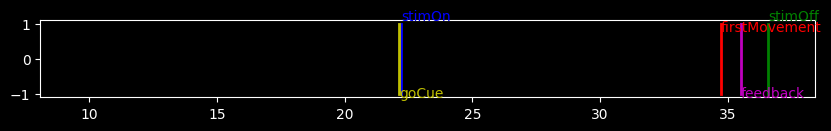

In [9]:
# Plot a numberline from intervals. intervals is a list of (start, end) tuples
plt.figure(figsize=(10, 1))
numberline = np.arange(tr['intervals'][tr_idx][0], tr['intervals'][tr_idx][1], 0.1)
plt.plot(numberline, np.zeros_like(numberline), 'k', lw=2)

# put a vertical line at stimOn_times, stimOff_times, goCue_times, feedback_times and label them
plt.plot([tr['stimOn_times'][tr_idx]] * 2, [-1, 1], 'b', lw=2)
plt.plot([tr['stimOff_times'][tr_idx]] * 2, [-1, 1], 'g', lw=2)
plt.plot([tr['goCue_times'][tr_idx]] * 2, [-1, 1], 'y', lw=2)
plt.plot([tr['feedback_times'][tr_idx]] * 2, [-1, 1], 'm', lw=2)
plt.plot([tr['firstMovement_times'][tr_idx]] * 2, [-1, 1], 'r', lw=2)

# label them
plt.text(tr['stimOn_times'][tr_idx], 1.1, 'stimOn', color='b')
plt.text(tr['stimOff_times'][tr_idx], 1.1, 'stimOff', color='g')
plt.text(tr['goCue_times'][tr_idx], -1.1, 'goCue', color='y')
plt.text(tr['feedback_times'][tr_idx], -1.1, 'feedback', color='m')
plt.text(tr['firstMovement_times'][tr_idx], 0.8, 'firstMovement', color='r')

plt.show()

## Stacked Ethograms

In [10]:
def plot_ethograms(ax, data, labels, time_values=None, move_onset = None, stimOn = None, stimOff = None, feedback = None,  title = "Ethograms of Models, Ensemble Mode, and Variance"):
    # Disable x-axis autoscaling
    ax.set_autoscalex_on(False)


    num_models = 6  # The first 6 rows are model predictions
    num_frames = data.shape[1]

    # Ensure time_values is valid or default to frame indices
    if time_values is not None:
        if len(time_values) != num_frames:
            raise ValueError("time_values must have the same length as the number of frames in data.")
        x_values = np.array(time_values)
        x_label = "Time (s)"
    else:
        x_values = np.arange(num_frames)
        x_label = "Frames"


    # Extract predictions and variance
    predictions = data[:6]  # First 6 rows: model predictions
    e_var = data[6].astype(float)  # Last row: ensemble variance

    # Map class labels to integers
    class_to_int = {label: i for i, label in enumerate(labels)}
    try:
        int_predictions = np.vectorize(class_to_int.get)(predictions)
    except KeyError:
        raise ValueError("Some labels in predictions are not in the provided labels list.")

    # Define colors for the ethogram based on the number of classes
    colors = ['red', 'blue', 'green', 'purple']
    cmap = ListedColormap(colors)

    # Plot predictions for each model and ensemble
    for i in range(num_models):
        ax.bar(
            x_values,
            height=1,
            width=np.diff(x_values, append=x_values[-1])[0],
            bottom=i + 1,  # Shift all predictions down by 1 to leave room for variance
            color=cmap(int_predictions[i]),
            edgecolor="none",  # No vertical edges
            alpha=1,
        )

    # Plot variance as its own row
    variance_cmap = plt.get_cmap('Greys')  # White to black for variance
    ax.bar(
        x_values,
        height=1,
        width=np.diff(x_values, append=x_values[-1])[0],
        bottom=0,  # Variance is the topmost row
        color=variance_cmap(e_var),
        edgecolor="none",  # No edges for variance
        alpha=1,
    )

    # Draw horizontal black lines between rows
    for i in range(1, num_models + 2):  # +2 to include variance row
        ax.hlines(y=i, xmin=x_values[0], xmax=x_values[-1], color='black', linewidth=1)


    if move_onset is not None:
        ax.axvline(x=move_onset, color='k', linestyle='--', linewidth=2, label='firstMovement')
        ax.text(move_onset, 0.2, 'First Move Onset', color='k', clip_on=True)

    if stimOn is not None:
        ax.axvline(x=stimOn, color='w', linestyle='-', linewidth=2, label='stimOn')
        ax.text(stimOn, 1.2, 'Stim On', color='w', clip_on=True)
    
    if stimOff is not None:
        ax.axvline(x=stimOff, color='w', linestyle='-', linewidth=2, label='stimOff')
        ax.text(stimOff, 2.2, 'Stim Off', color='w', clip_on=True)
    
    if feedback is not None:
        ax.axvline(x=feedback, color='w', linestyle='-', linewidth=2, label='feedback')
        ax.text(feedback, 3.2, 'Feedback', color='w', clip_on=True)

    # Configure centered y-ticks
    y_positions = np.arange(num_models + 1) + 0.5  # +1 for variance row
    ax.set_yticks(y_positions)
    ax.set_yticklabels(["Variance"] + ["Ensemble", "Model 5", "Model 4", "Model 3", "Model 2", "Model 1"])

    # Configure plot aesthetics
    ax.set_xlabel(x_label)
    ax.set_xlim(x_values[0], x_values[-1])
    ax.set_ylim(0, num_models + 1)  # +1 for variance row
    ax.set_title(title)
    ax.grid(False)


In [11]:
# Simulated data_df example
labels = ["Still", "Move", "Wheel Turn", "Groom"]
predictions = data_df[['e_mode', 'mod_5', 'mod_4', 'mod_3', 'mod_2', 'mod_1', "e_var"]].values.T

In [61]:
def slice_timelines(data, w_back, w_forward):
    start = np.searchsorted(data_df['cam_times'], w_back)
    end = np.searchsorted(data_df['cam_times'], w_forward)
    x_axis = np.linspace(w_back, w_forward, end - start)
    return data[:, start:end], x_axis, start, end

In [13]:
def plot_ethogram_stacks(start_trial, rows= 10, cols=2):

    fig, axs = plt.subplots(rows, cols, figsize=(25, 2*rows), dpi=300, sharey=True)

    for idx, ax in enumerate(axs.flatten()):
        time_sec = tr['firstMovement_times'][start_trial + idx]
        stim_on = tr['stimOn_times'][start_trial + idx]
        stim_off = tr['stimOff_times'][start_trial + idx]
        feedback = tr['feedback_times'][start_trial + idx]


        etho, x_axis, f_s, f_e = slice_timelines(predictions, w_back = time_sec - .5, w_forward = time_sec + 1)
        plot_ethograms(ax, 
                        etho, 
                        labels, 
                        time_values=x_axis, 
                        move_onset = time_sec,
                        stimOn = stim_on,
                        stimOff=stim_off,
                        feedback=feedback,
                        title=f"Trial {start_trial + idx+1}, First Movement Time: {time_sec:.2f}s")

    axs[0,0].legend( [Line2D([0], [0], marker='.', color='w', markerfacecolor='red', markersize=15),
            Line2D([0], [0], marker='.', color='w', markerfacecolor='blue', markersize=15),
            Line2D([0], [0], marker='.', color='w', markerfacecolor='green', markersize=15),
            Line2D([0], [0], marker='.', color='w', markerfacecolor='purple', markersize=15)],
            ['Still', 'Move', 'Wheel Turn', 'Groom'], loc='upper right', frameon=True)

    plt.tight_layout()
    plt.show()

In [14]:
# plot_ethogram_stacks(0)

## Etho with video

In [15]:
col_map = {"red": "Still", "blue": "Move", "green": "Wheel Turn", "purple": "Groom"}
inv_map = {"Still": "red", "Move": "blue", "Wheel Turn": "green", "Groom": "purple"}

def get_video_frames(start, end):
    
    # read the video frames
    cap = cv2.VideoCapture(vid_url)

    our_frames = []
    for i in range(0, end):
        ret, frame = cap.read()
        if i >= start:
            our_frames.append(frame)

    # Release the VideoCapture object
    cap.release()
    return np.array(our_frames)

In [16]:
def make_vid_viz(etho, frames, paws, x_axis, etho_kwargs, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 3), dpi=200, width_ratios=[3, 1])

    etho_ax = axs[0]
    vid_ax = axs[1]

    # Plot the ethogram
    plot_ethograms(etho_ax, etho, labels, time_values=x_axis, title="Ethogram (-0.5s to +1s)", **etho_kwargs)

    # Plot the video
    vid_ax.axis('off')
    mouse_img = vid_ax.imshow(frames[0])
    paw = vid_ax.scatter(paws[0, 0], paws[0, 1], color='r', s=10)
    vid_ax.set_title("Video Frame")

    timeline = etho_ax.axvline(x=0, color='k', linestyle='-', label='Current Frame')

    plt.suptitle(title)

    def animate(i):
        timeline.set_xdata([x_axis[i], x_axis[i]])
        mouse_img.set_data(frames[i])
        paw.set_offsets(np.c_[paws[i, 0], paws[i, 1]])

    ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=1000/fps, blit=False, cache_frame_data=False, repeat=True)
    plt.tight_layout()
    plt.close()
    return ani

In [62]:
def visualize_trial(i, complete=False):
    f_move_time = tr['firstMovement_times'][i]

    etho_kwargs = {
        "move_onset": f_move_time,
        "stimOn": tr['stimOn_times'][i],
        "stimOff": tr['stimOff_times'][i],
        "feedback": tr['feedback_times'][i]
    }

    if complete:
        w_s, w_e = tr['intervals'][i]
        etho, x_axis, f_s, f_e = slice_timelines(predictions, w_back = w_s, w_forward = w_e)
    else:
        etho, x_axis, f_s, f_e = slice_timelines(predictions, w_back = f_move_time - .5, w_forward = f_move_time + 1)

    frames = get_video_frames(f_s, f_e)
    paws = data_df[f_s:f_e][['paw_x_pos', 'paw_y_pos']].values
    ani = make_vid_viz(etho, frames, paws, x_axis, etho_kwargs=etho_kwargs, title=f"Trial {i+1}, First Movement Time: {f_move_time:.2f}s", )
    return HTML(ani.to_html5_video())

In [18]:
# visualize_trial(40 - 1)

In [19]:
# visualize_trial(56 - 1)

## Wheel speed vs first movement

In [20]:
ws = data_df["wheel_speed"]
fmt = tr['firstMovement_times']

In [21]:
x = data_df["cam_times"]

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


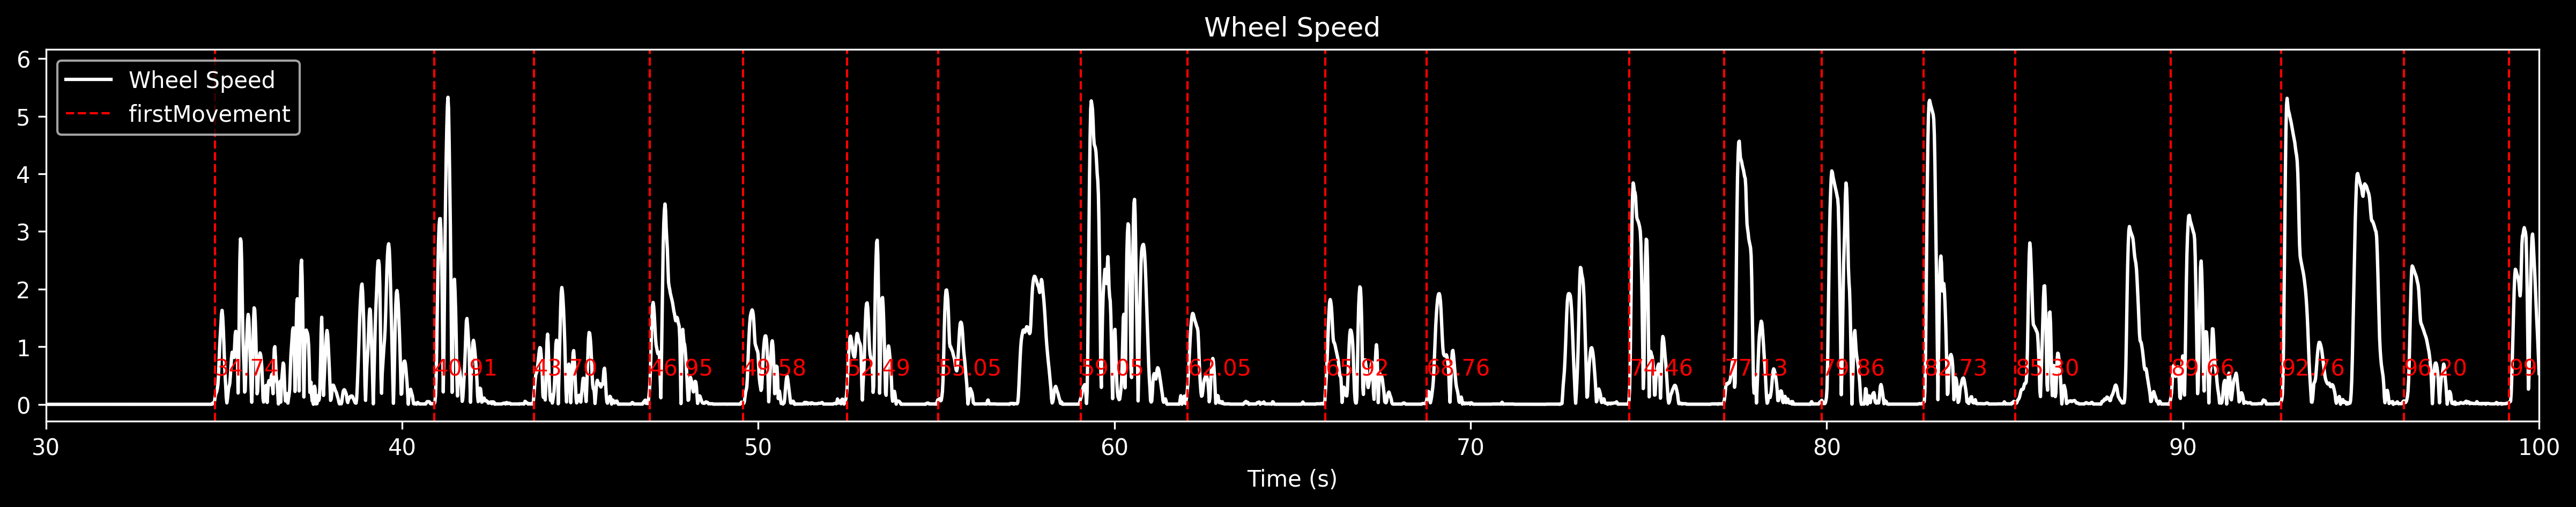

In [22]:
plt.figure(figsize=(20, 3), dpi=300)
plt.plot(x, ws, "w-", label="Wheel Speed")
for idx, fm in enumerate(fmt):
    plt.axvline(fm, color='r', linestyle='--', linewidth=1, label='firstMovement' if idx == 0 else None)
    plt.text(fm, 0.5, f"{fm:.2f}", color='r', clip_on=True)

plt.title("Wheel Speed")
plt.xlabel("Time (s)")
plt.legend()
plt.xlim(30, 100)
plt.show()

## Var stack Raster

In [176]:
ct = data_df["cam_times"]

In [177]:
interval_df = pd.DataFrame(tr['intervals'], columns=['start', 'end'])
interval_df["frame_start"] = np.searchsorted(ct, interval_df["start"]).astype(int)
interval_df["frame_end"] = np.searchsorted(ct, interval_df["end"]).astype(int)
interval_df["firstMovement_times"] = tr["firstMovement_times"]
interval_df["frame_fmt"] = np.searchsorted(ct, interval_df["firstMovement_times"])
interval_df["stimOn_times"] = tr["stimOn_times"]
interval_df["stimOff_times"] = tr["stimOff_times"]
interval_df["feedback_times"] = tr["feedback_times"]
interval_df["trial_idx"] = np.arange(0, len(interval_df))

In [178]:
# from data_df, e_var column, calculate the average variance within the frame_start and frame_end
def calculate_avg_var(row):
    # Ensure frame_start and frame_end are valid integers
    frame_start = max(0, int(row["frame_start"]))
    frame_end = min(len(data_df) - 1, int(row["frame_end"]))  # Ensure within bounds
    # Return the mean of e_var for the valid range
    return data_df["e_var"].iloc[frame_start:frame_end].mean()

# Apply the function to calculate avg_var
interval_df["avg_var"] = interval_df.apply(calculate_avg_var, axis=1)

In [179]:
interval_df.head()

,start,end,frame_start,frame_end,firstMovement_times,frame_fmt,stimOn_times,stimOff_times,feedback_times,trial_idx,avg_var
0,9.453855,37.077944,0,935,34.742615,794,22.211612,36.577909,35.512448,0,0.012839
1,37.557844,42.639065,963,1269,40.908615,1165,40.805652,42.138986,41.072559,1,0.037805
2,43.020064,45.894675,1292,1464,43.695615,1332,43.511415,45.394660,44.323967,2,0.047786
3,46.250175,48.744589,1486,1635,46.947615,1527,46.739026,48.244542,47.169783,3,0.025913
4,49.102189,51.455616,1657,1798,49.575615,1685,49.671899,50.955571,49.895110,4,0.083206


In [180]:
def make_raster_data(some_df):
    # temporary holder for the data
    ens_raster_holder = np.zeros((len(some_df), (some_df["frame_end"] - some_df["frame_start"]).max()))
    ens_raster_holder[:] = np.nan
    var_raster_holder = np.zeros_like(ens_raster_holder)
    var_raster_holder[:] = np.nan

    for idx, row in some_df.iterrows():
        start = int(row["frame_start"])
        end = int(row["frame_end"])
        class_to_int = {label: i for i, label in enumerate(labels)}
        ens_raster_holder[idx, :end - start] = data_df["e_mode"][start:end].map(class_to_int).values
        var_raster_holder[idx, :end - start] = data_df["e_var"][start:end].values

    return ens_raster_holder, var_raster_holder, some_df["trial_idx"].values + 1

In [181]:
def plot_raster(er, vr, yticks = None, xlim = 175, title = "Rasters of Trials over Time"):
    # plt.style.use('default')
    colors = ['red', 'blue', 'green', 'purple']
    cmap = ListedColormap(colors)

    fig, axs = plt.subplots(1,2, figsize=(20, 10), dpi=300)

    ens_ax = axs[0]
    var_ax = axs[1]

    sns.heatmap(er, cmap=cmap, cbar=False, ax=ens_ax)
    ens_ax.set_title("Raster of Ensemble Mode States")
    ens_ax.set_xlabel("Frames")
    ens_ax.set_ylabel("Trials")
    ens_ax.set_xlim(0, xlim)
    ens_ax.set_xticks(np.arange(0, xlim, max(1, xlim // 10)))
    ens_ax.set_xticklabels(np.arange(0, xlim, max(1, xlim // 10)))

    ens_ax.legend([
        Line2D([0], [0], marker='.', color='w', markerfacecolor='red', markersize=15),
        Line2D([0], [0], marker='.', color='w', markerfacecolor='blue', markersize=15),
        Line2D([0], [0], marker='.', color='w', markerfacecolor='green', markersize=15),
        Line2D([0], [0], marker='.', color='w', markerfacecolor='purple', markersize=15)
        ],
        ['Still', 'Move', 'Wheel Turn', 'Groom'], loc='upper right', frameon=True)

    sns.heatmap(vr, cmap="rocket", cbar=True, ax=var_ax)
    var_ax.set_title("Raster of Ensemble Mode Variance")
    var_ax.set_xlabel("Frames")
    var_ax.set_ylabel("Trials")
    var_ax.set_xlim(0, xlim)
    var_ax.set_xticks(np.arange(0, xlim, max(1, xlim // 10)))
    var_ax.set_xticklabels(np.arange(0, xlim, max(1, xlim // 10)))

    if yticks is not None:
        # Set yticks and labels for ensemble raster
        ens_ax.set_yticks(np.arange(len(yticks)))
        ens_ax.set_yticklabels(yticks, rotation=0, fontsize=5)

        # Set yticks and labels for variance raster
        var_ax.set_yticks(np.arange(len(yticks)))
        var_ax.set_yticklabels(yticks, rotation=0, fontsize=5)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

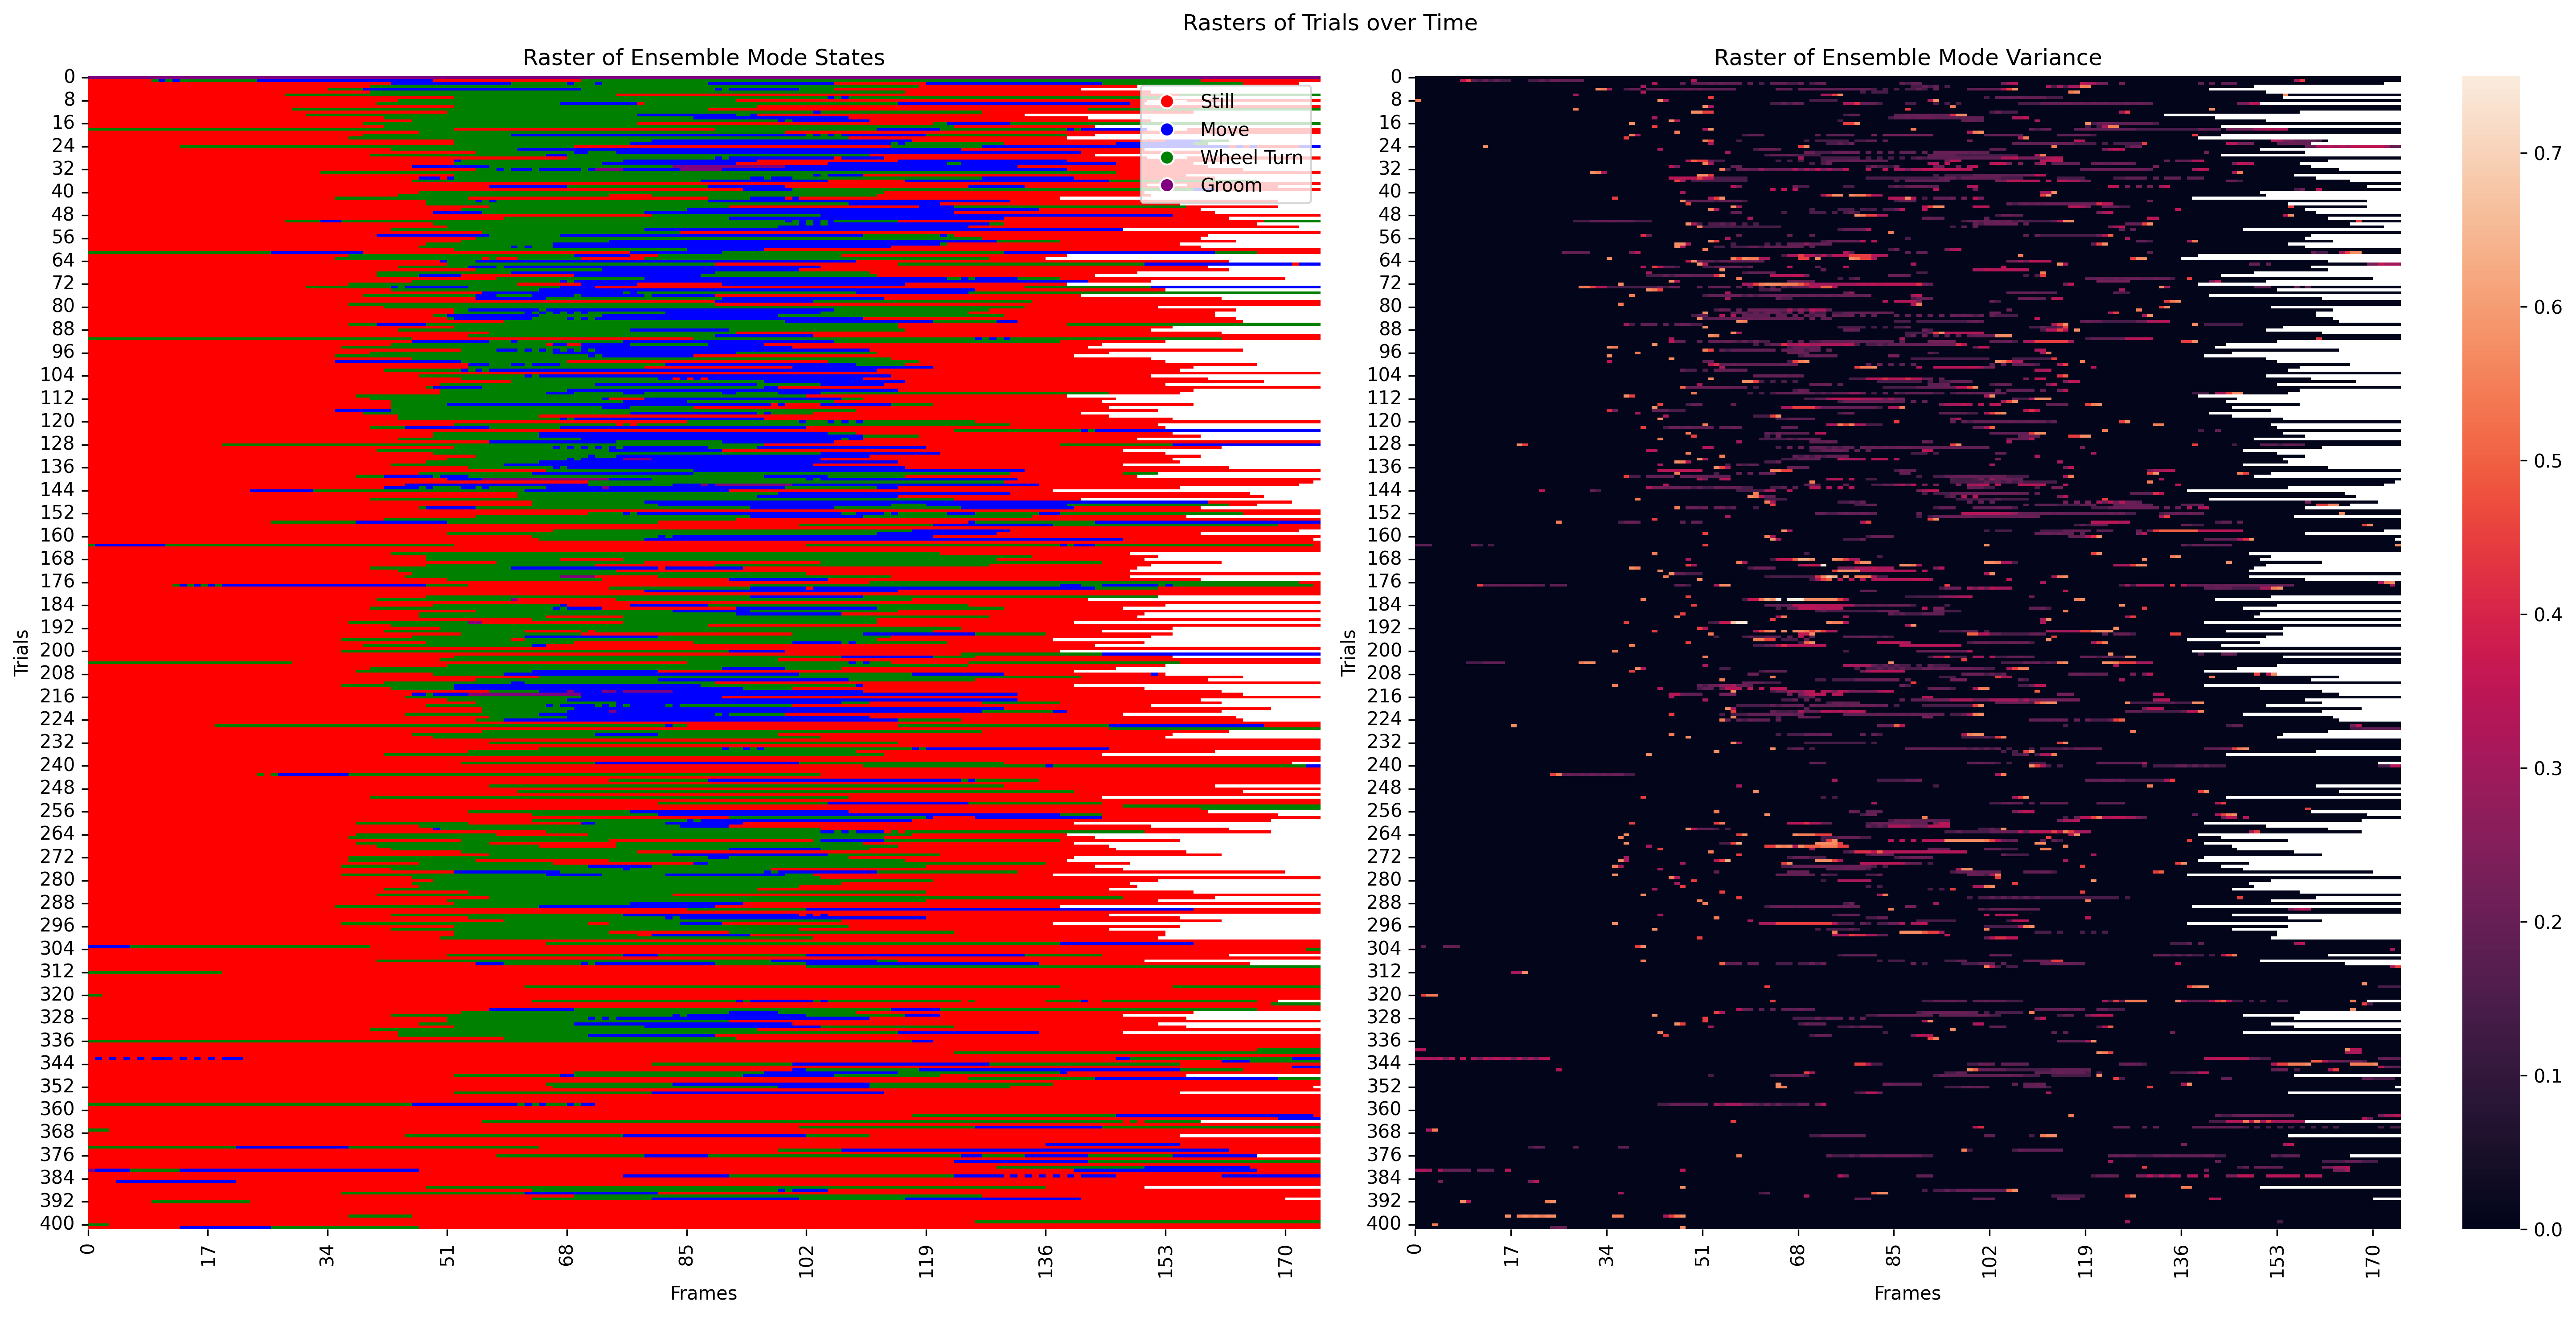

In [182]:
ens_raster, var_raster, trial_idx = make_raster_data(interval_df)
plot_raster(ens_raster[:], var_raster[:])

In [183]:
# colors = ['red', 'blue', 'green', 'purple']
# cmap = ListedColormap(colors)
# plt.figure(figsize=(28, 15), dpi=300)
# sns.heatmap(ens_raster, cmap=cmap, cbar=False)
# plt.title("Raster of Ensemble Mode States")
# plt.xlabel("Frames")
# plt.ylabel("Trials")
# plt.tight_layout()

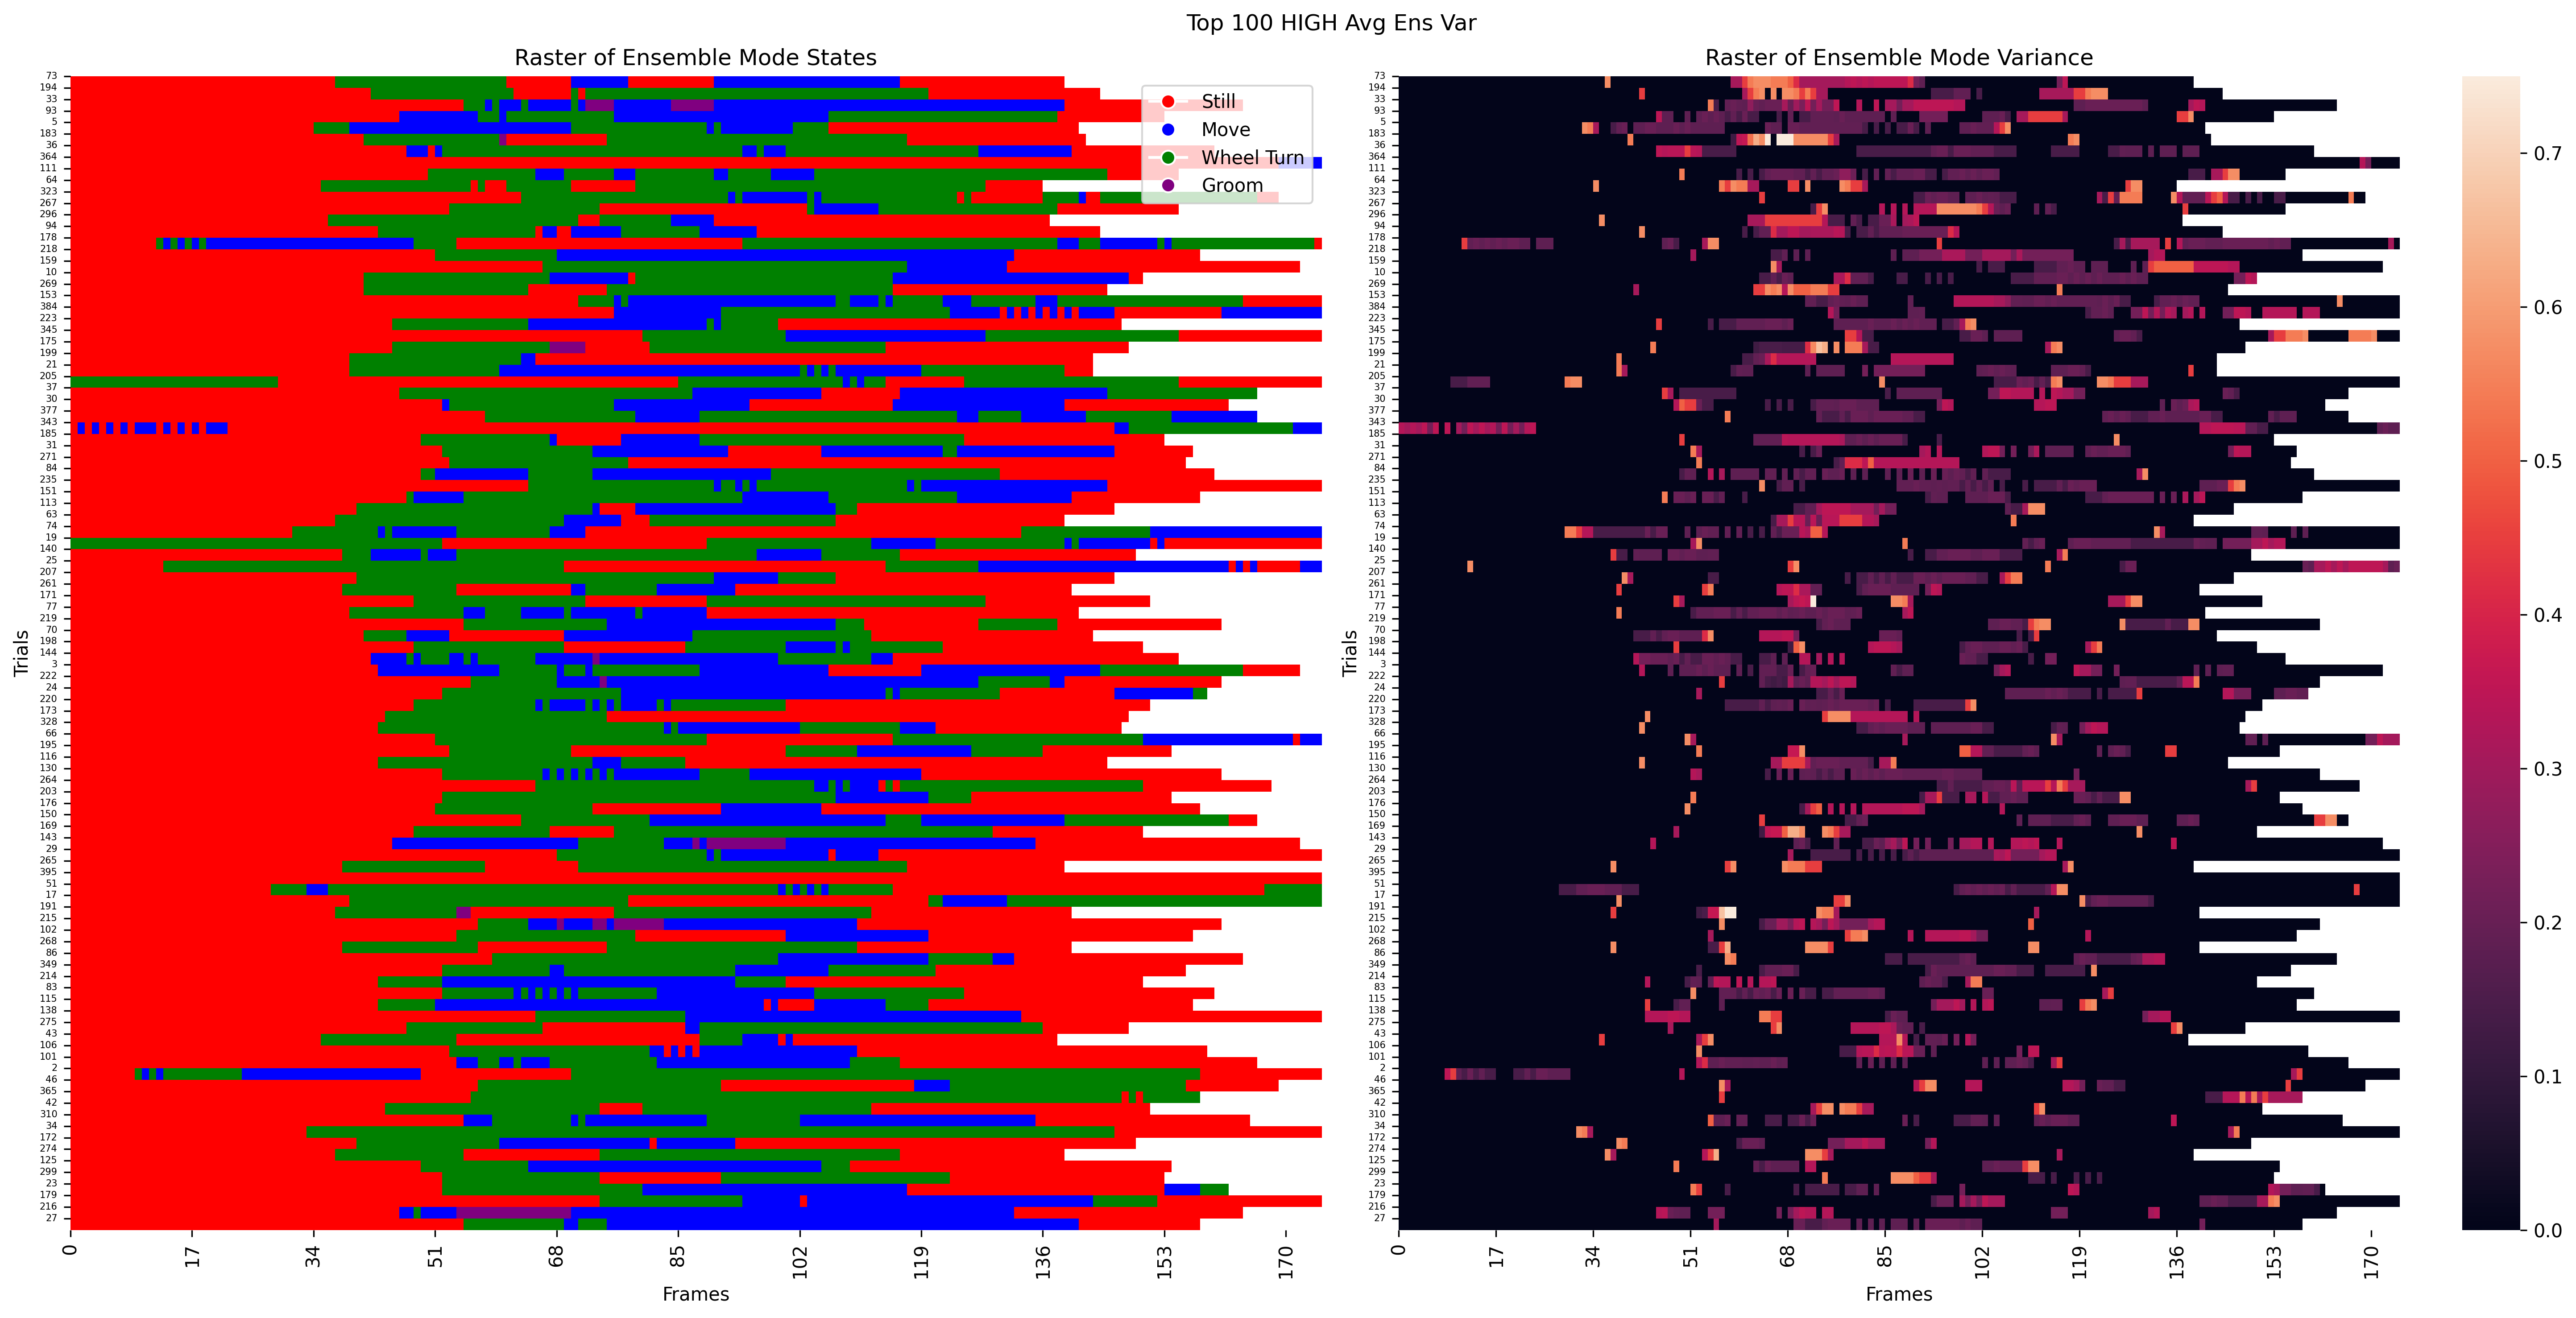

In [184]:
sorted_df = interval_df.sort_values(by='avg_var', ascending=False).copy()
sens_raster, svar_raster, strial_idx = make_raster_data(sorted_df.reset_index(drop=True))
limit = 100
plot_raster(sens_raster[:limit], svar_raster[:limit], strial_idx[:limit], title="Top 100 HIGH Avg Ens Var")

In [185]:
# visualize_trial(73 - 1, complete=True)

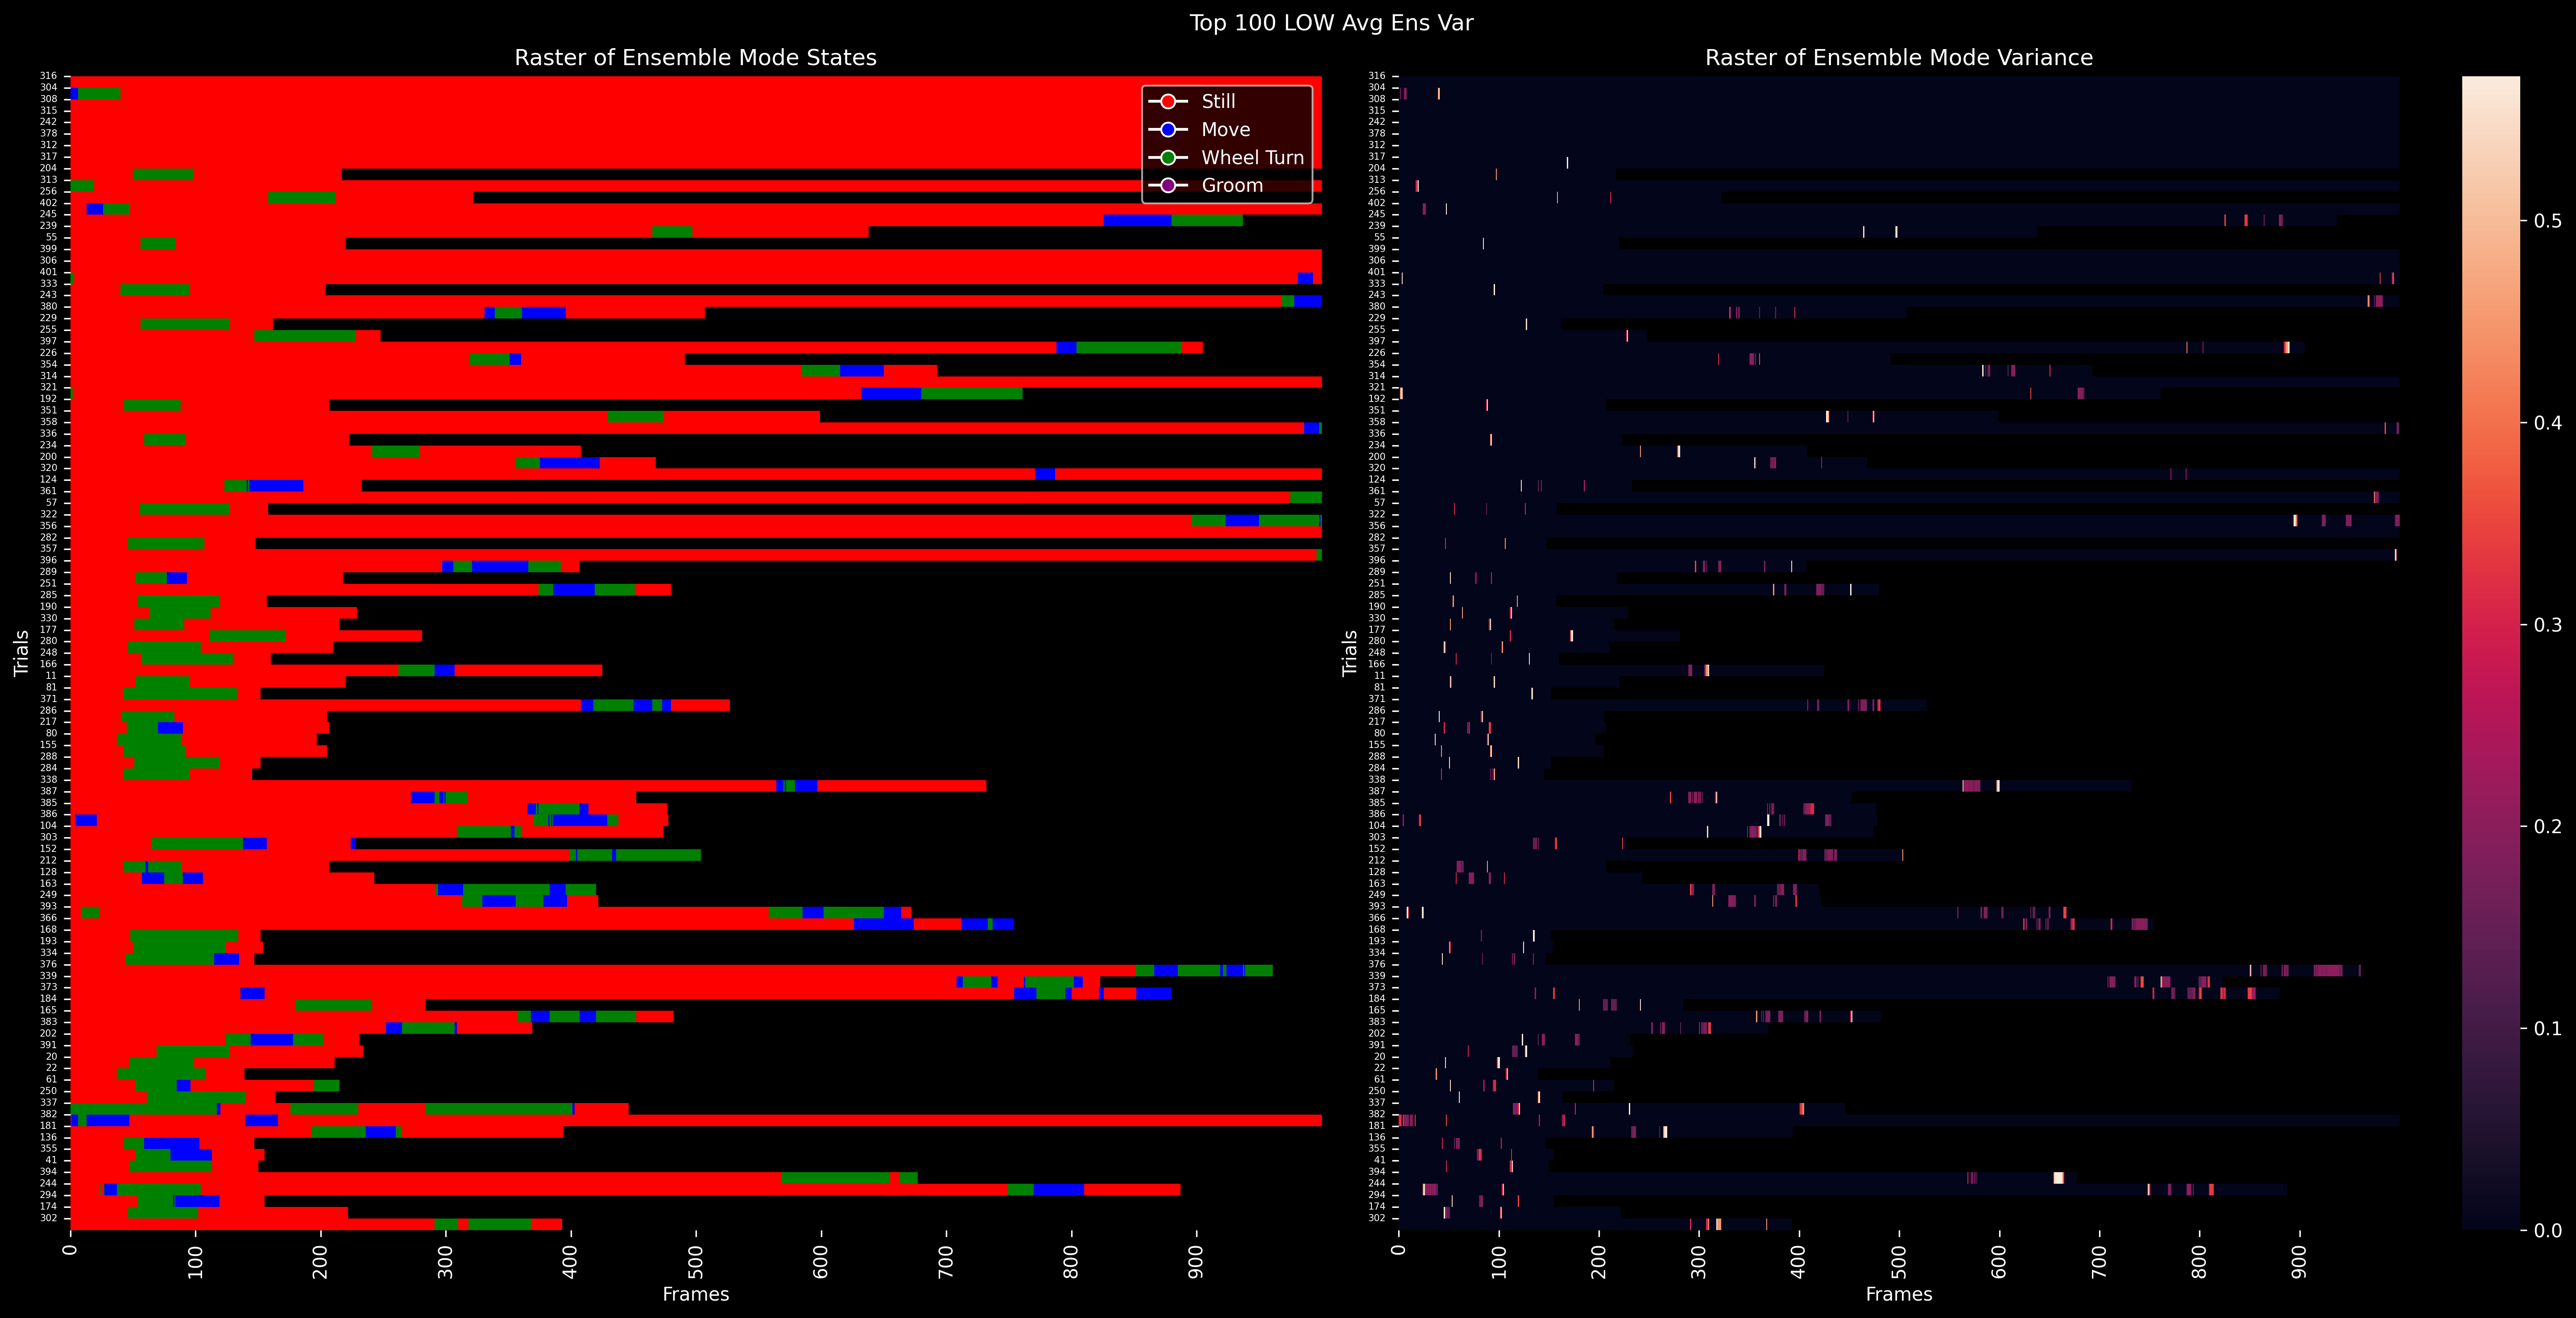

In [76]:
sorted_df = interval_df.sort_values(by='avg_var', ascending=True).copy()
sens_raster, svar_raster, strial_idx = make_raster_data(sorted_df.reset_index(drop=True))
limit = 100
plot_raster(sens_raster[:limit], svar_raster[:limit], strial_idx[:limit], xlim=1000, title="Top 100 LOW Avg Ens Var")

In [77]:
sens_raster.shape

(402, 3830)

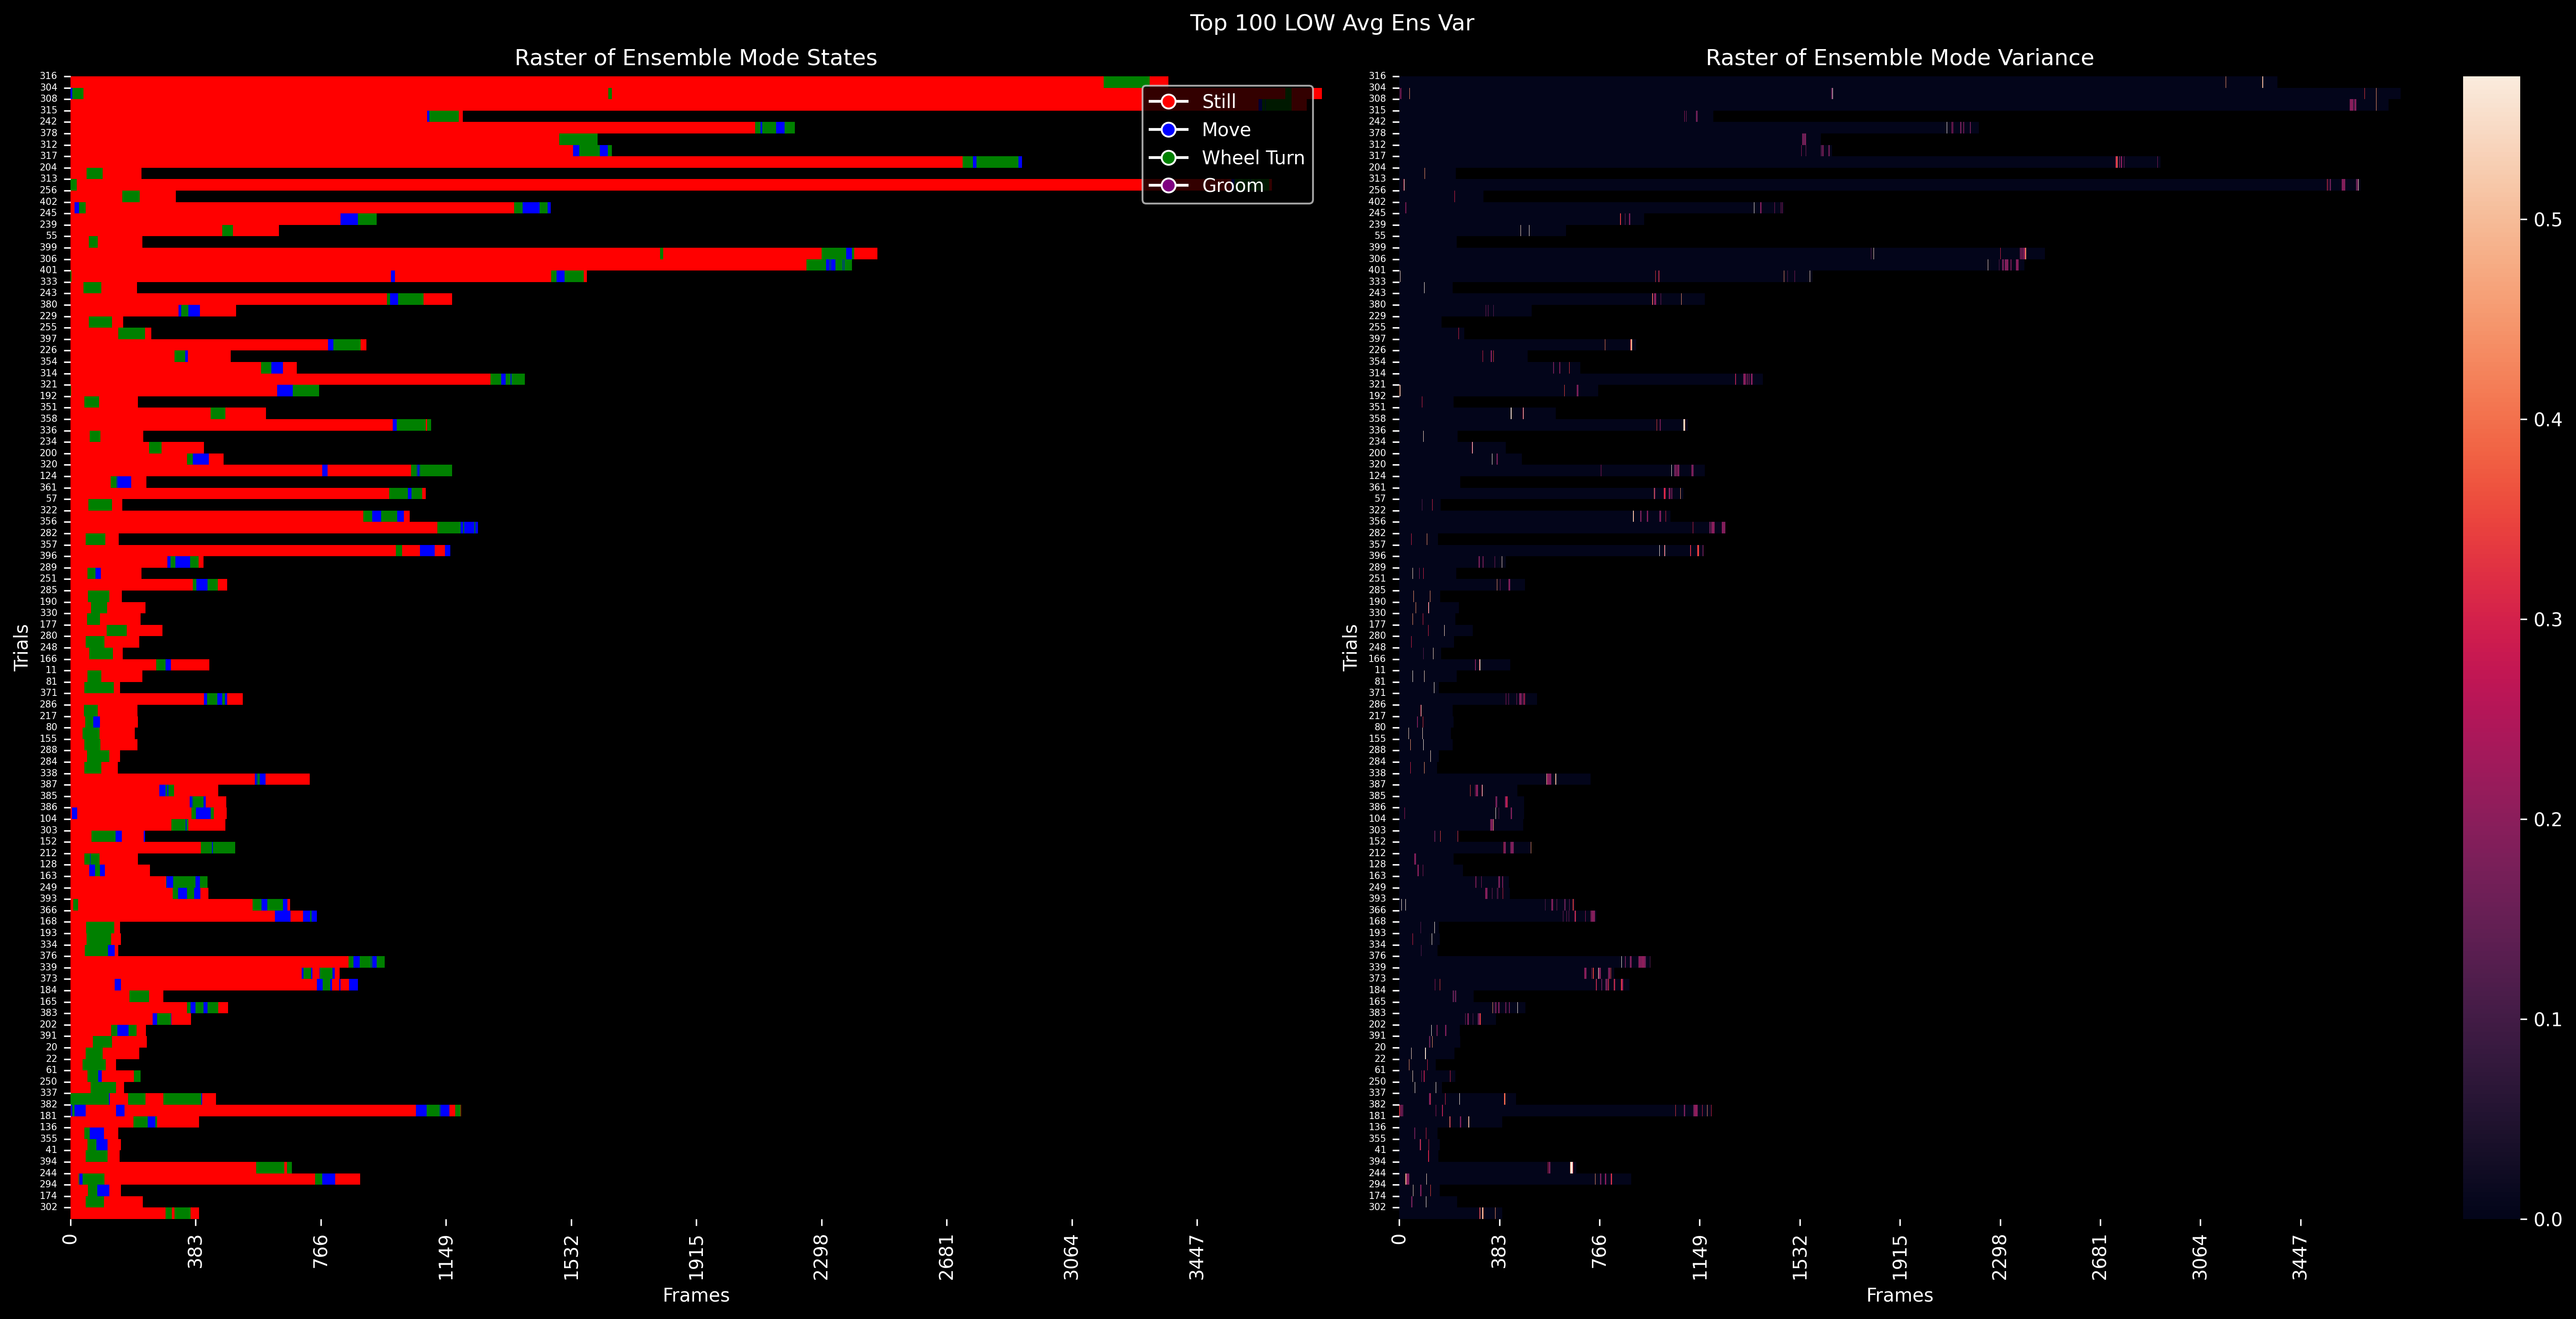

In [78]:
sorted_df = interval_df.sort_values(by='avg_var', ascending=True).copy()
sens_raster, svar_raster, strial_idx = make_raster_data(sorted_df.reset_index(drop=True))
limit = 100
plot_raster(sens_raster[:limit], svar_raster[:limit], strial_idx[:limit], xlim=3830, title="Top 100 LOW Avg Ens Var")

### Silencing the +-5 frames around the transitions

In [ ]:
# Identify transition frames
model_to_use = 'e_mode'

any_transition_frames = data_df[
    (data_df[model_to_use].shift() != data_df[model_to_use])
].index

tdf = data_df.copy()

silence_window = 5
# Make it so that +- 5 frames around the transition frames are also set to 0
for frame in any_transition_frames:
    tdf.loc[frame - silence_window:frame + silence_window, 'e_var'] = 0

In [ ]:
sorted_df = interval_df.sort_values(by='avg_var', ascending=False).copy()
sens_raster, svar_raster, strial_idx = make_raster_data(sorted_df.reset_index(drop=True), data_df=tdf)
limit = 100
plot_raster(sens_raster[:limit], svar_raster[:limit], strial_idx[:limit], title="Top 100 HIGH Avg Ens Var")

In [ ]:
sorted_df = interval_df.sort_values(by='avg_var', ascending=True).copy()
sens_raster, svar_raster, strial_idx = make_raster_data(sorted_df.reset_index(drop=True), data_df=tdf)
limit = 100
plot_raster(sens_raster[:limit], svar_raster[:limit], strial_idx[:limit], xlim=3830, title="Top 100 LOW Avg Ens Var")

## State duration histograms

In [133]:
sd_df = data_df[["e_mode", "cam_times", "frame_id"]].copy()
sd_df

,e_mode,cam_times,frame_id
0,Groom,21.526414,0
1,Groom,21.543079,1
2,Groom,21.559711,2
3,Groom,21.576376,3
4,Groom,21.593008,4
...,...,...,...
207995,Still,3484.251374,207995
207996,Still,3484.268005,207996
207997,Still,3484.284670,207997
207998,Still,3484.301302,207998


In [134]:
# Step 1: Identify continuous state segments
sd_df['group'] = (sd_df['e_mode'] != sd_df['e_mode'].shift()).cumsum()

# Step 2: Calculate the duration of each frame
sd_df['frame_duration'] = sd_df['cam_times'].shift(-1) - sd_df['cam_times']

# Handle the NaN value for the last frame (no next frame to subtract)
sd_df['frame_duration'] = sd_df['frame_duration'].fillna(1/60)

# Step 3: Sum frame durations within each group to get state durations
durations = sd_df.groupby('group').agg(
    e_mode=('e_mode', 'first'),
    duration=('frame_duration', 'sum')
).reset_index(drop=True)

In [135]:
durations

,e_mode,duration
0,Groom,13.185315
1,Move,0.133187
2,Wheel Turn,1.065460
3,Move,0.316335
4,Wheel Turn,0.016632
...,...,...
2744,Move,0.133187
2745,Wheel Turn,0.016665
2746,Move,0.016632
2747,Wheel Turn,0.233077


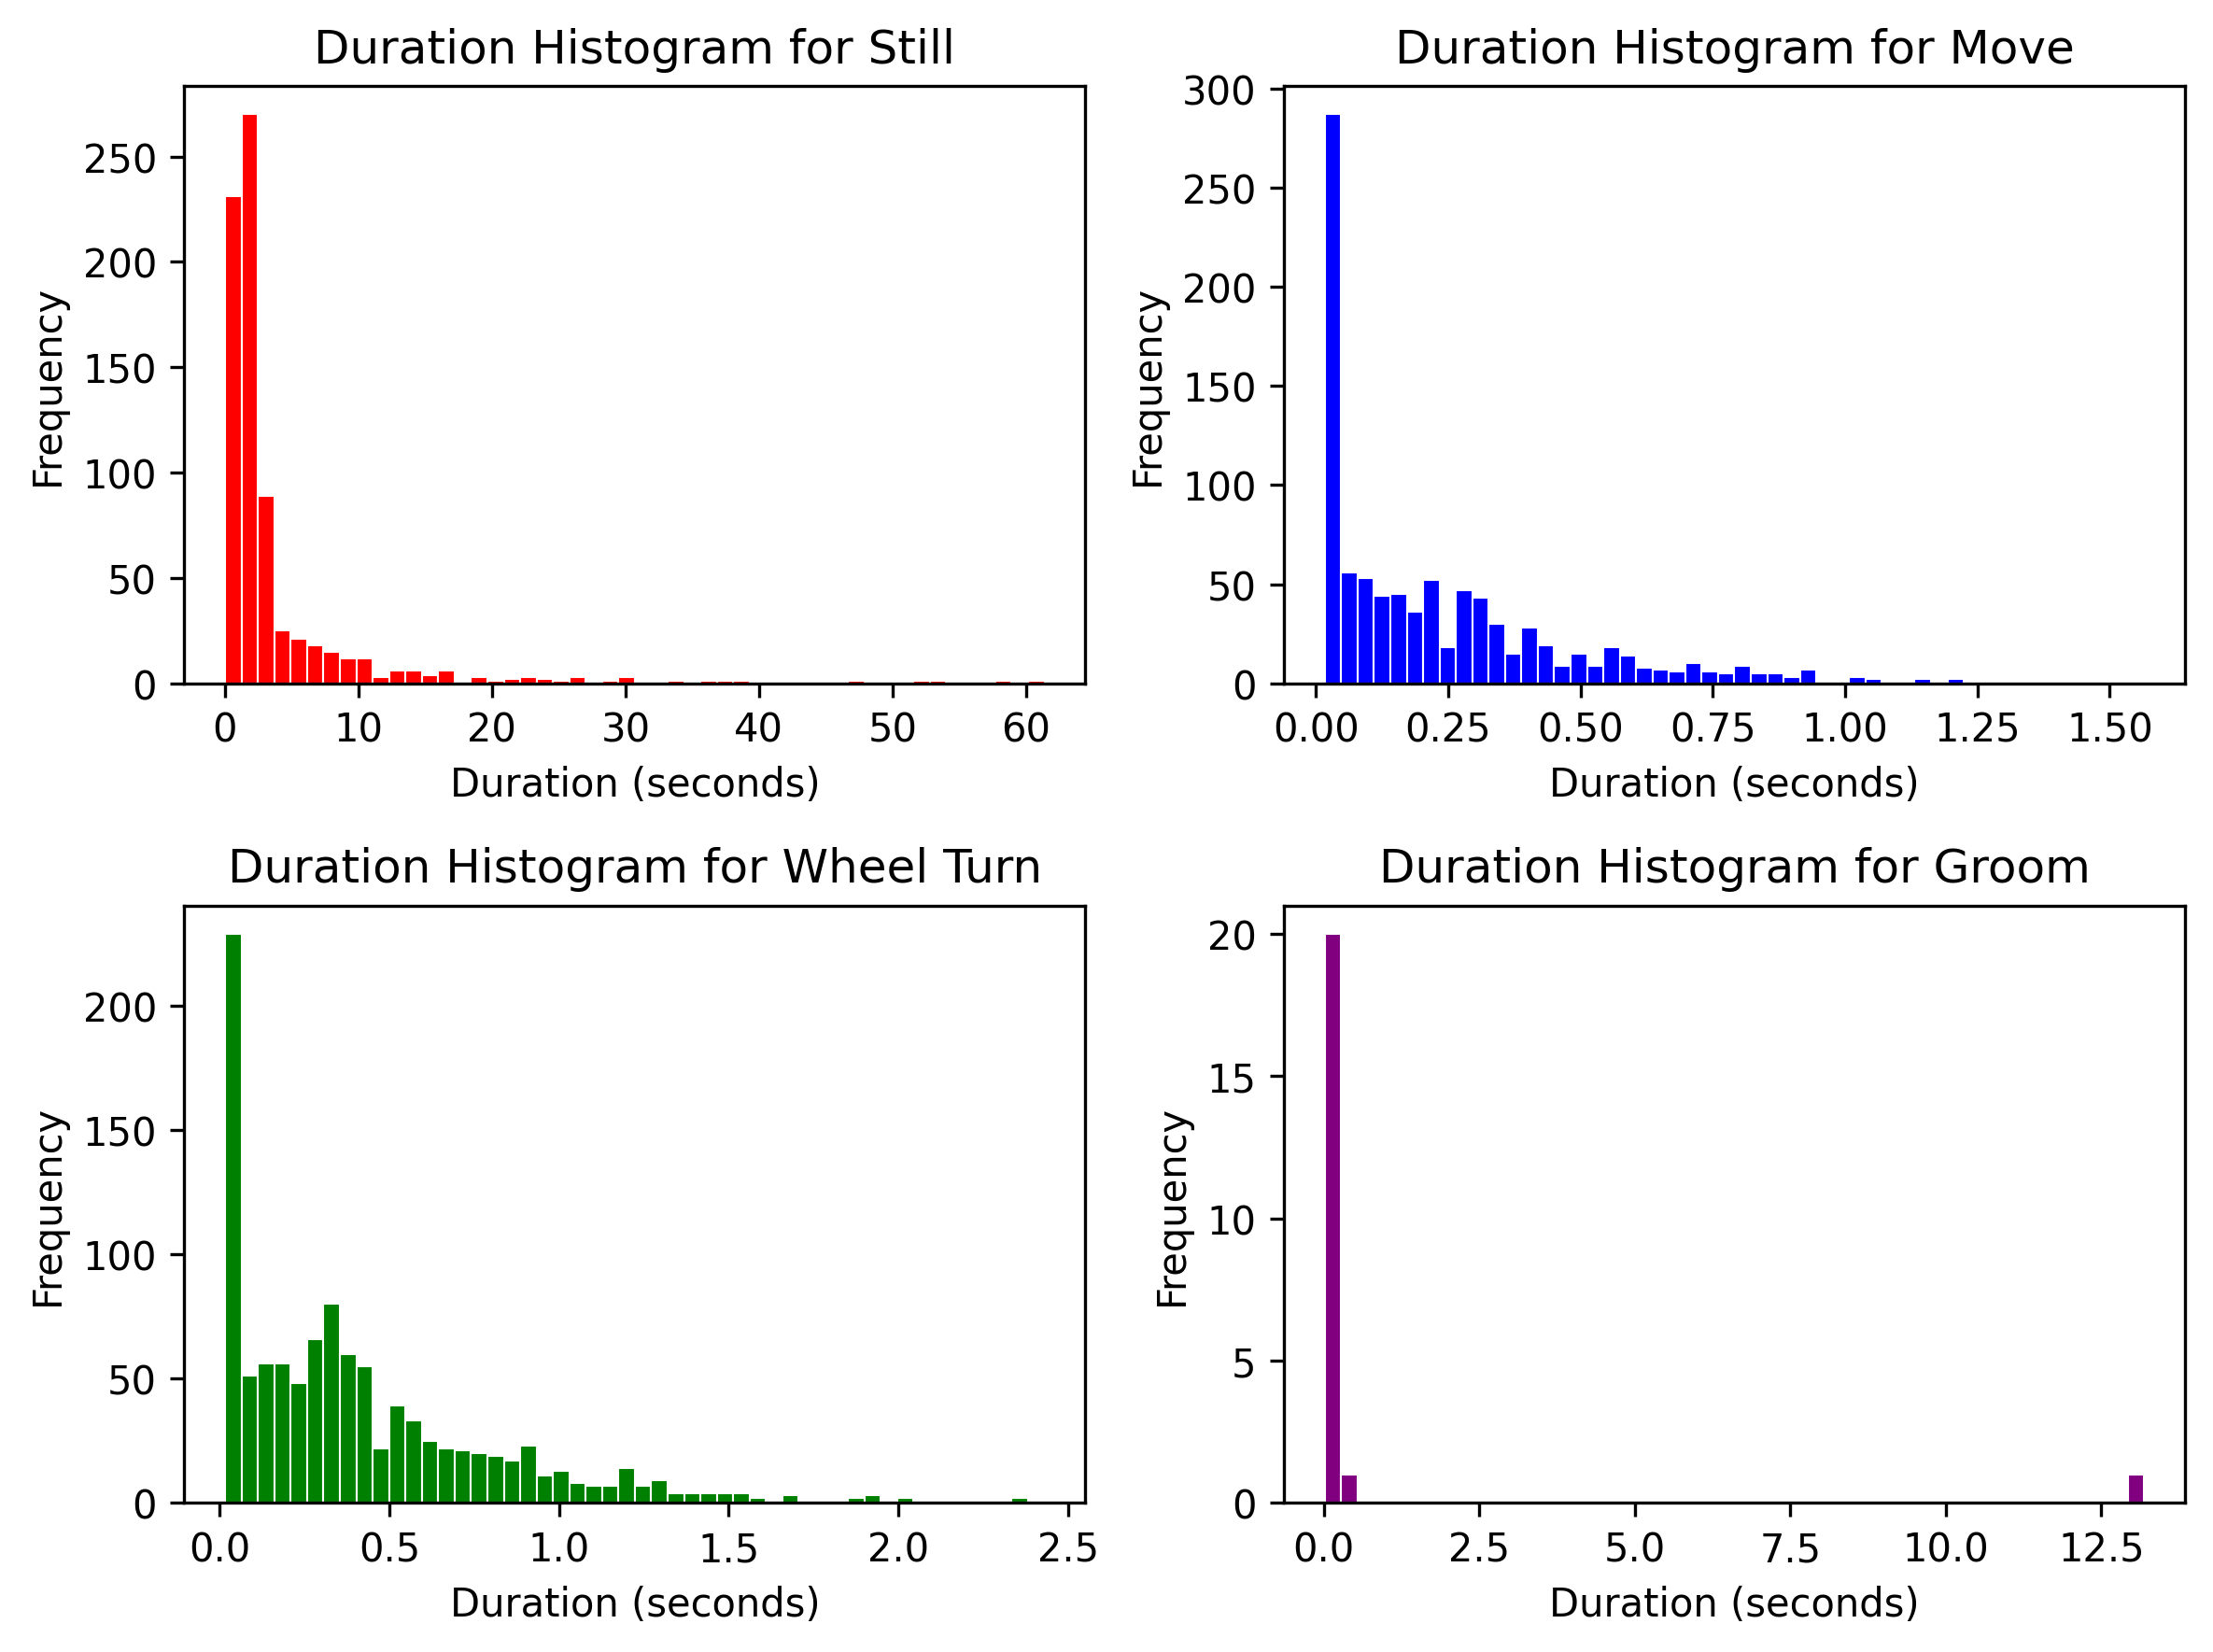

In [175]:
# Step 4: Plot histograms for each 'e_mode' state
plt.style.use('default')
fig, axs = plt.subplots(2, 2, figsize=(8, 6), dpi = 300)
states = ['Still', 'Move', 'Wheel Turn', 'Groom']
colors = ['red', 'blue', 'green', 'purple']
for idx, ax in enumerate(axs.flatten()):
    state_data = durations[durations['e_mode'] == states[idx]]['duration']

    ax.hist(state_data, bins=50, edgecolor='white', linewidth=0.5, color=colors[idx])
    ax.set_title(f'Duration Histogram for {states[idx]}')
    ax.set_xlabel('Duration (seconds)')
    ax.set_ylabel('Frequency')
    # ax.grid(True)
plt.tight_layout()
plt.show()

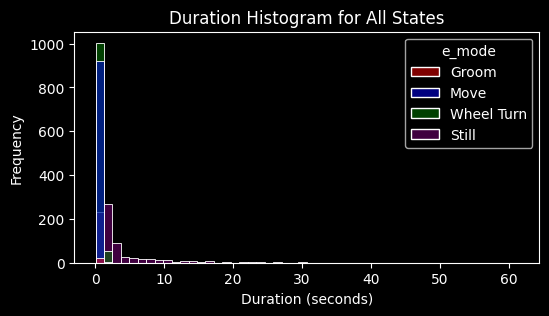

In [137]:
# Visualize the duration 
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
sns.histplot(durations, x='duration', hue='e_mode', bins=50, palette=colors, ax=ax)
ax.set_title('Duration Histogram for All States')
ax.set_xlabel('Duration (seconds)')
ax.set_ylabel('Frequency')
plt.show()

In [152]:
# combine the state durations with themselves and make bargraphs

# Step 1: Calculate the total duration per state
total_durations = durations.groupby('e_mode')['duration'].sum().reset_index()

# Optional: Sort the states by total duration (descending order)
total_durations.sort_values('duration', ascending=False, inplace=True)

color_map = {state: color for state, color in zip(states, colors)}
total_durations['color'] = total_durations['e_mode'].map(color_map)
total_durations

,e_mode,duration,color
2,Still,2790.424298,red
3,Wheel Turn,441.474115,green
1,Move,216.009664,blue
0,Groom,14.900143,purple


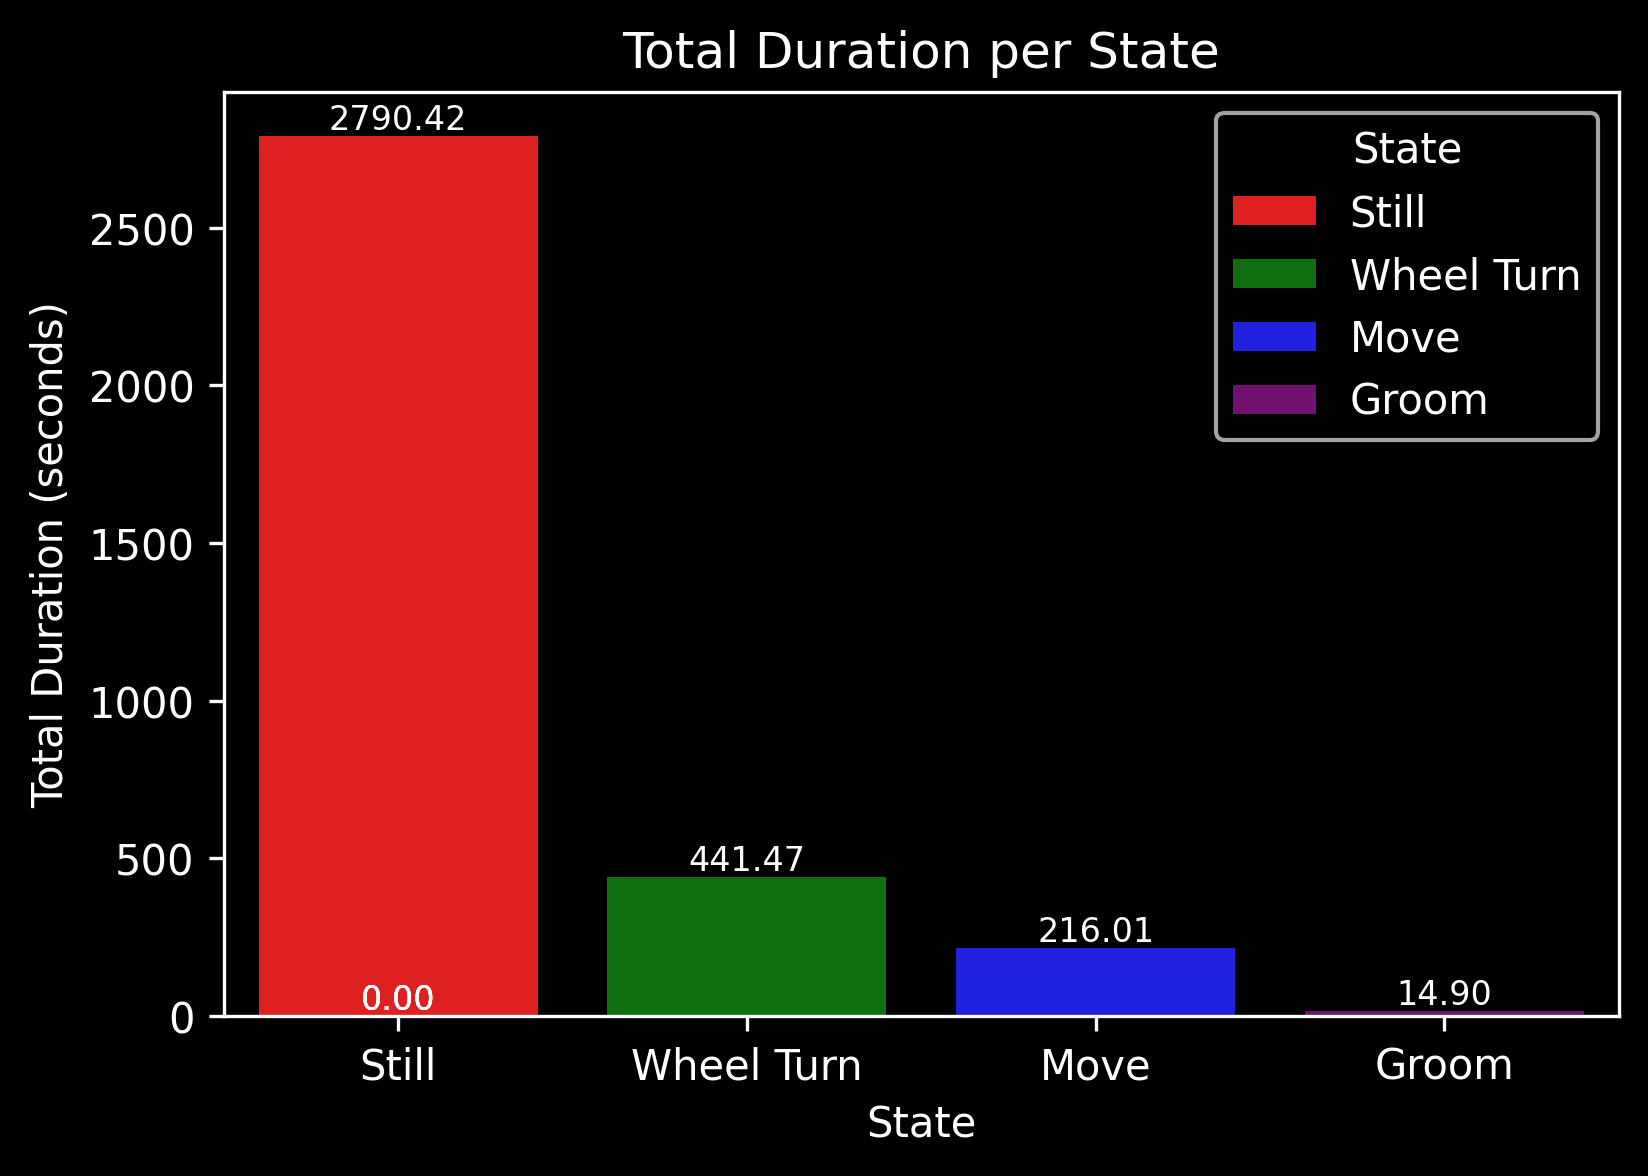

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
colors = total_durations['color'].tolist()
bp = sns.barplot(data=total_durations, x='e_mode', y='duration', hue='e_mode', palette=colors, ax=ax, legend=True)

# Add labels to the top of each bar
for bar in bp.patches:
    bar_height = bar.get_height()
    bar_x = bar.get_x() + bar.get_width() / 2
    ax.text(bar_x, bar_height, f'{round(bar_height, 2):.2f}', ha='center', va='bottom', fontsize=8)


bp.get_legend().set_title('State')
ax.set_title('Total Duration per State')
ax.set_xlabel('State')
ax.set_ylabel('Total Duration (seconds)')
plt.show()